In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib
import math
import seaborn as sns
import numpy as np
import pandas as pd
import psycopg2
import psycopg2.extras
from datetime import timedelta, datetime

import sys 
sys.path.append('../Python-modules/') #For bee_helpers and file_helpers 
from bee_helpers import calc_trip_lengths, calc_trip_starts, get_forager_bee_ids, get_random_bee_ids, get_all_bee_ids
from file_helpers import cache_location_prefix, detections_to_presence, detections_to_presence_locations, create_presence_cache_filename, create_presence_locations_cache_filename, create_presence_cache_filename, cache_location_prefix, create_presence_locations_cam_cache_filename

import bb_utils
import bb_utils.meta
import bb_utils.ids
import bb_backend
from bb_backend.api import FramePlotter, VideoPlotter
from bb_backend.api import get_plot_coordinates, transform_axis_coordinates, get_image_origin
from pathlib import Path

from tqdm import tqdm
meta = bb_utils.meta.BeeMetaInfo()
BeesbookID = bb_utils.ids.BeesbookID

/usr/local/lib/python3.5/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [3]:
datetime_start = datetime(2016, 7, 19) #TODO: set beginning date as default param in file helpers
num_days_to_process = 60
num_intervals_per_hour = 60 #TODO: if considered 
num_hours = 24 #TODO: set as default param in file helpers

In [5]:
presence_dfs = []


for i in range(0, num_days_to_process):
    start_day = datetime_start+timedelta(days=i)
    (csv_name, csv_path) = create_presence_cache_filename(num_hours, start_day, num_intervals_per_hour)
    file = Path(csv_path)
    if file.exists() == False:
        print(csv_path+ " doesn't exist")
    else: 
        new_presence_df = pd.read_csv(csv_path).iloc[:,1:]
        new_presence_df = new_presence_df.drop(columns='id')
        presence_dfs.append(new_presence_df)
        print("Adding df #"+str(i)+", "+csv_name)

../../caches/Presence/PRESENCE-2016-07-19_00_num_hours_24_int_size_60.csv doesn't exist
Adding df #1, PRESENCE-2016-07-20_00_num_hours_24_int_size_60.csv
Adding df #2, PRESENCE-2016-07-21_00_num_hours_24_int_size_60.csv
Adding df #3, PRESENCE-2016-07-22_00_num_hours_24_int_size_60.csv
Adding df #4, PRESENCE-2016-07-23_00_num_hours_24_int_size_60.csv
Adding df #5, PRESENCE-2016-07-24_00_num_hours_24_int_size_60.csv
Adding df #6, PRESENCE-2016-07-25_00_num_hours_24_int_size_60.csv
Adding df #7, PRESENCE-2016-07-26_00_num_hours_24_int_size_60.csv
Adding df #8, PRESENCE-2016-07-27_00_num_hours_24_int_size_60.csv
Adding df #9, PRESENCE-2016-07-28_00_num_hours_24_int_size_60.csv
Adding df #10, PRESENCE-2016-07-29_00_num_hours_24_int_size_60.csv
Adding df #11, PRESENCE-2016-07-30_00_num_hours_24_int_size_60.csv
Adding df #12, PRESENCE-2016-07-31_00_num_hours_24_int_size_60.csv
Adding df #13, PRESENCE-2016-08-01_00_num_hours_24_int_size_60.csv
Adding df #14, PRESENCE-2016-08-02_00_num_hours_24

In [6]:
presence_df = pd.concat(presence_dfs, axis=1)
presence_df.index.rename('bee_id', inplace=True)

In [50]:
sum_pres_by_bee = presence_df.sum(axis=1)

In [22]:
# presence_df.to_csv('../../caches/Presence/COMBINED_PRESENCE_59d_24h_from_07-19.csv')

In [ ]:
# presence_df = pd.read_csv('../../caches/Presence/COMBINED_PRESENCE_59d_24h_from_07-19.csv', index_col='bee_id')

In [51]:
lives_from_detections_df = pd.read_csv('../../caches/Other/lives_from_detections_df.csv', index_col='bee_id', parse_dates=['min', 'max'])

In [52]:
sum_pres_by_bee = sum_pres_by_bee.to_frame()
sum_pres_by_bee.columns = ['presence_score_total']

In [53]:
sum_pres_by_bee.head()

,presence_score_total
bee_id,
0,10.0
1,2.0
2,8.0
3,1.0
4,71.0


In [54]:
lives_from_detections_df.head()

,min,max,lifespan
bee_id,,,
2,2016-08-03,2016-08-21,18.0
4,2016-07-30,2016-08-24,25.0
5,2016-07-30,2016-08-25,26.0
8,2016-07-30,2016-08-16,17.0
9,2016-07-19,2016-08-06,18.0


In [55]:
presence_with_lifespan = sum_pres_by_bee.join(lives_from_detections_df, how='outer')

In [56]:
presence_with_lifespan['presence_coefficient'] = presence_with_lifespan.presence_score_total/(presence_with_lifespan.lifespan*1440)

In [57]:
presence_with_lifespan_fil = presence_with_lifespan.dropna()

In [58]:
presence_with_lifespan_work = presence_with_lifespan_fil[presence_with_lifespan_fil.lifespan > 0]

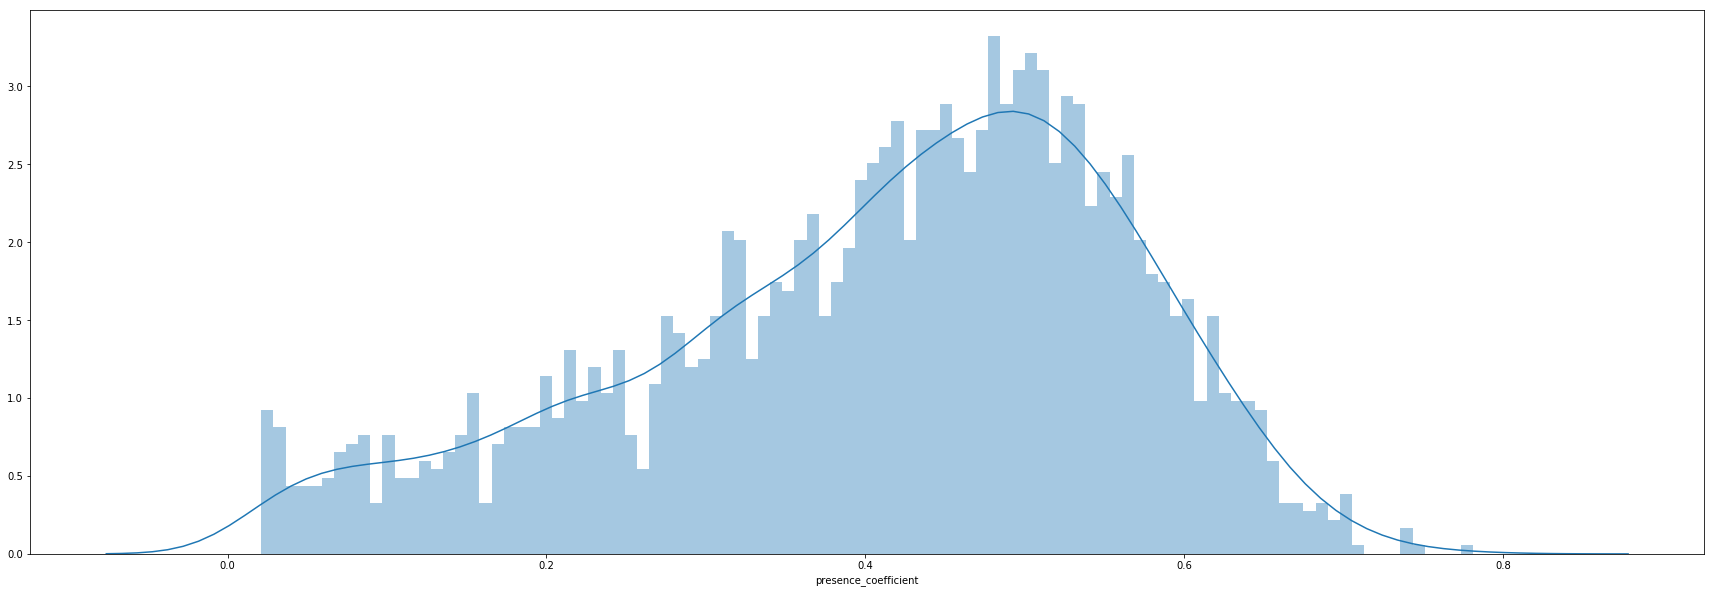

In [59]:
fig, ax = plt.subplots()
fig.set_size_inches(30, 10)
preshist = (presence_with_lifespan_work[presence_with_lifespan_work.presence_coefficient > 0.02]).presence_coefficient
ax = sns.distplot(preshist, bins=100)

In [60]:
presence_with_lifespan_work.head()

,presence_score_total,min,max,lifespan,presence_coefficient
bee_id,,,,,
2,8.0,2016-08-03,2016-08-21,18.0,0.000309
4,71.0,2016-07-30,2016-08-24,25.0,0.001972
5,4.0,2016-07-30,2016-08-25,26.0,0.000107
8,104.0,2016-07-30,2016-08-16,17.0,0.004248
9,3953.0,2016-07-19,2016-08-06,18.0,0.152508


In [61]:
pres_by_minute = presence_df.sum(axis='rows')

In [62]:
pres_by_hour = []
for i in np.arange(0, 1416): #24hours * 59 days 
    newHour = pres_by_minute[i*60:(i+1)*60].sum()
    pres_by_hour.append(newHour)

In [63]:
pres_by_hour = pd.DataFrame(pres_by_hour, columns=['presence'])

In [64]:
pres_days = presence_df.iloc[:,60*7:]
presence_days_list = [] 

for i in np.arange(0, 59): #24hours * 59 days 
    begin = i*60*12
    end = begin+60*12
    daytime = pres_days.iloc[:,begin:end]
    presence_days_list.append(daytime)
    
presence_days = pd.concat(presence_days_list, axis=1)
presence_days.shape

(4096, 42480)

In [65]:
daily_presences = []

for i in np.arange(0, 59): #24hours * 59 days 
    begin = i*60*24
    end = begin+60*24
    day = presence_df.iloc[:,begin:end]
    daily_presences.append(day.sum(axis=1))
    
daily_presences = pd.concat(daily_presences, axis=1)
daily_presences = daily_presences/1440
daily_presences = daily_presences.loc[presence_with_lifespan_work.index]

In [66]:
daily_presences.head()

,0,1,2,3,4,5,6,7,8,9,...,49,50,51,52,53,54,55,56,57,58
bee_id,,,,,,,,,,,,,,,,,,,,,
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000694,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000694,0.000000,0.0,0.000694,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.622222,0.672222,0.618056,0.594444,0.234722,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [67]:
presence_with_lifespan_work.head()

,presence_score_total,min,max,lifespan,presence_coefficient
bee_id,,,,,
2,8.0,2016-08-03,2016-08-21,18.0,0.000309
4,71.0,2016-07-30,2016-08-24,25.0,0.001972
5,4.0,2016-07-30,2016-08-25,26.0,0.000107
8,104.0,2016-07-30,2016-08-16,17.0,0.004248
9,3953.0,2016-07-19,2016-08-06,18.0,0.152508


In [68]:
pres_by_ages = daily_presences*0 #create a DataFrame with the same shape and labels, but empty 
day_0 = datetime(2016, 7, 20)

In [69]:
pres_by_ages.head()

,0,1,2,3,4,5,6,7,8,9,...,49,50,51,52,53,54,55,56,57,58
bee_id,,,,,,,,,,,,,,,,,,,,,
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [72]:
for day in pres_by_ages.columns:
    print(day)
    for bee in pres_by_ages.index:
        bee_birth_day = presence_with_lifespan_work.loc[bee]['min'].day
        #did this bee live to day x? 
        if presence_with_lifespan_work.loc[bee]['lifespan'] < day:
            pres_by_ages.loc[bee, day] = np.nan
        else:
            pres_by_ages.loc[bee, day] = daily_presences.loc[bee, bee_birth_day]

pres_by_ages.head()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58


,0,1,2,3,4,5,6,7,8,9,...,49,50,51,52,53,54,55,56,57,58
bee_id,,,,,,,,,,,,,,,,,,,,,
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [85]:
(pres_by_ages.isna().sum(axis=0)/pres_by_ages.shape[0]).head()

0    0.000000
1    0.000000
2    0.018470
3    0.052394
4    0.074256
dtype: float64

In [86]:
sns.pres_by_ages.mean()

0     0.101905
1     0.101905
2     0.103822
3     0.107536
4     0.110075
5     0.114115
6     0.119618
7     0.124063
8     0.127694
9     0.131996
10    0.136596
11    0.141530
12    0.146831
13    0.154991
14    0.161755
15    0.169034
16    0.178521
17    0.190602
18    0.203818
19    0.217951
20    0.230593
21    0.237686
22    0.242203
23    0.251205
24    0.260819
25    0.271456
26    0.281546
27    0.286498
28    0.289924
29    0.293584
30    0.296822
31    0.295507
32    0.296731
33    0.299807
34    0.304616
35    0.310028
36    0.310499
37    0.315007
38    0.308938
39    0.298740
40    0.299217
41    0.297610
42    0.274821
43    0.276190
44    0.277799
45    0.277729
46    0.282602
47    0.285443
48    0.290956
49    0.278330
50    0.272110
51    0.259556
52    0.254289
53    0.242468
54    0.242593
55    0.180903
56    0.170734
57    0.170734
58    0.239028
dtype: float64

In [226]:
daily_presences.shape

(2653, 59)

In [252]:
pres_by_ages

,0,1,2,3,4,5,6,7,8,9,...,4026,4033,4034,4036,4050,4052,4058,4061,4064,4092
bee_id,,,,,,,,,,,,,,,,,,,,,
2,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
8,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
9,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
10,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
17,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
20,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
21,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


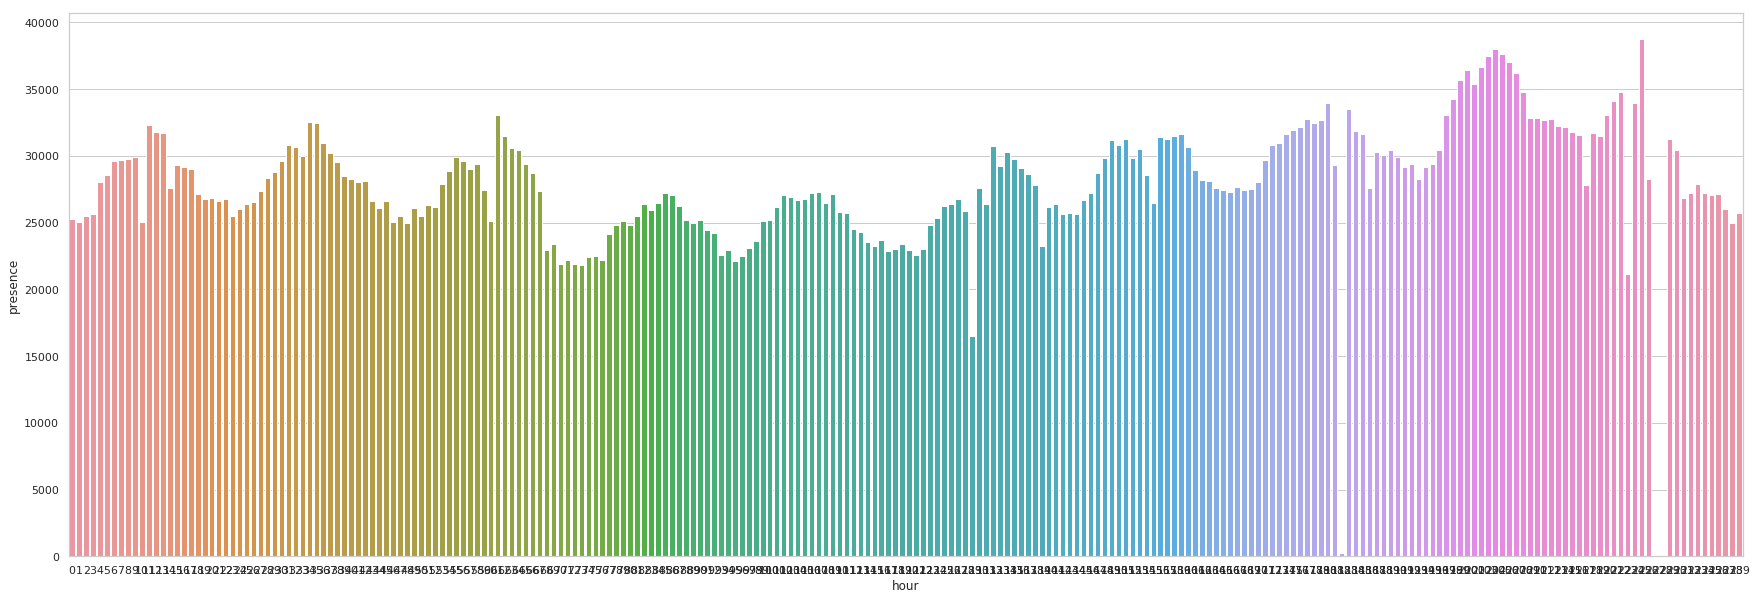

In [144]:
fig, ax = plt.subplots()
fig.set_size_inches(30,10)
pres_by_hour.index.name = 'hour'
pres_by_hour['hour'] = pres_by_hour.index
sns.barplot(x='hour', y='presence', data=pres_by_hour[:240], ax=ax)

In [ ]:
sum_pres_by_bee = pd.DataFrame(sum_pres_by_bee, columns=["presence_score_total"])

In [72]:
sum_pres_by_bee.max()

presence_score_total    58710.0
dtype: float64

In [60]:
spbdf = sum_pres_by_bee.loc[(sum_pres_by_bee!=0).any(1)]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8da9409da0>]],
      dtype=object)

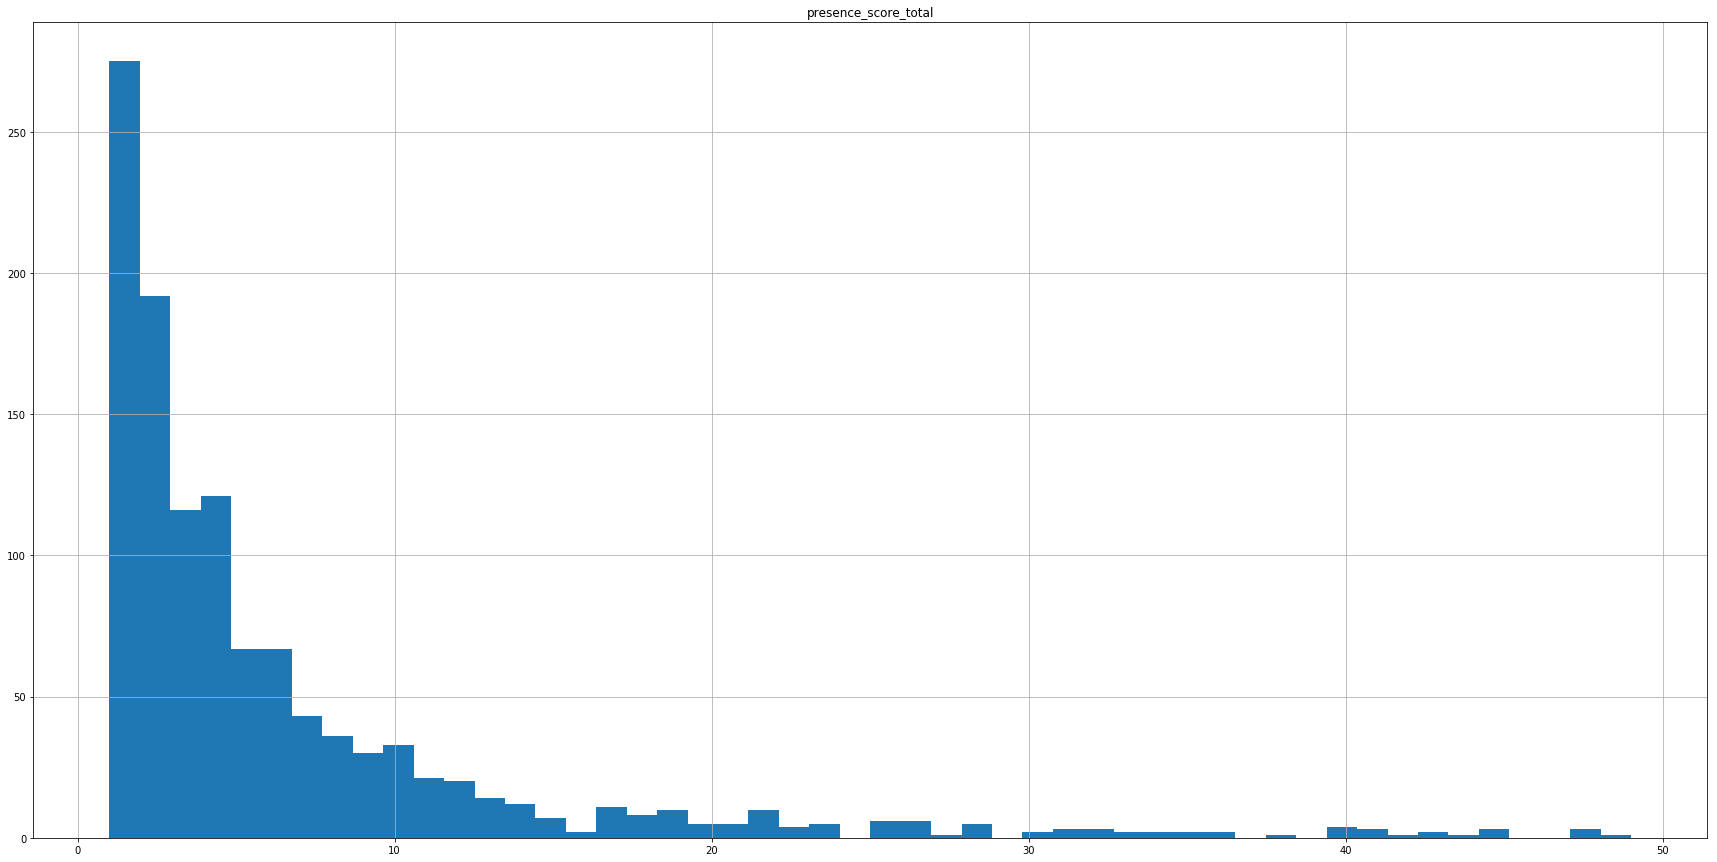

In [69]:
spbdf[spbdf.presence_score_total<50].hist(bins=50, figsize=(30,15))

In [38]:
sum_pres_filtered

array([   0,    1,    2, ..., 4093, 4094, 4095])